# Project: Masters thesis - structuring optimal portfolio based on selected asset classes
**Abstract:** Creating multiple asset allocation strategies based on:  
1. manually selected securities 
2. bond & multi-asset ETFs 
3. Single multi-asset ETF's portfolios 
4. SP500
And then determining best strategies based on total returs and time of entry/exit.
**Data:** Stocks & Securities data  
**Source:** https://stooq.com/


## 1. Setting-up project environment

### 1.1 Importing packages & data

In [1]:
from urllib.request import urlretrieve
from datetime import datetime
from scipy import stats
import pandas as pd
import mplfinance as mpl #https://pypi.org/project/mplfinance/
import os
import string
import re
import numpy as np
import matplotlib.pyplot as plt
import copy # for deep copying

#Requirements file creation
import session_info

#Python portfolio optimizer
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import CLA

from IPython.display import display, HTML
%matplotlib inline

# Setting pandas display options
pd.options.display.max_columns = 200
pd.options.display.max_rows = 100



In [2]:
# Collecting packages info and saving to requirements.txt file
session_info.show(cpu = True, std_lib = True, dependencies = True, write_req_file = True, req_file_name = 'requirements.txt')

Useful:  
* dir() #list of variables  
* %whos #list of objects in environment  

### Research and links:  

* Markdown : https://www.markdownguide.org/basic-syntax/
* Sortino ratio: https://www.investopedia.com/terms/s/sortinoratio.asp
* Sharpe ratio: http://web.stanford.edu/~wfsharpe/art/sr/sr.htm

Libraries to explore:  
* https://www.activestate.com/blog/top-10-python-packages-for-finance-and-financial-modeling/
* https://quantlib-python-docs.readthedocs.io/en/latest/
* https://github.com/quandl/quandl-python
* https://github.com/quantopian/pyfolio
* https://gbeced.github.io/pyalgotrade/docs/v0.20/html/tutorial.html

Stooq data:
* https://www.quantstart.com/articles/an-introduction-to-stooq-pricing-data/

Portfolio analysis:
* https://app.datacamp.com/learn/courses/introduction-to-portfolio-analysis-in-python 
* https://app.datacamp.com/learn/courses/quantitative-risk-management-in-python
* https://app.datacamp.com/learn/courses/introduction-to-portfolio-risk-management-in-python
* https://app.datacamp.com/learn/courses/bond-valuation-and-analysis-in-python


### 1.2 Establishing portfolio parameters

In [3]:
# PARAMETERS for calculations

# Stocks & weights might be better represented by a dictionary - think about it later
portfolio_dict = {'AAPLUS' : 0.25,
                  'MSFTUS' : 0.25,
                  'AMZNUS' : 0.25,
                  'NVDAUS' : 0.25
                 }
# securities chosen  for your porfolio "SPX","V80ADE","WIG","PKO"
# weights for your securities in portfolio. Number of weights must match number of securities

#portfolio_stocks = ['AAPLUS','MSFTUS','AMZNUS','NVDAUS'] 2023/01/16 - test if all is working
#portfolio_weights = np.array([0.25, 0.25, 0.25 ,0.25]) 
capital = 100000 #starting capital
rfr = 0.0 # risk-free-rate
target_return = 0.0 # target return for Sortino ratio

In [4]:
ticker_list = ['WIG','WIG20','^SPX','V80A.DE','^TBSP','EURPLN','USDPLN','BTC.V','XAGPLN','XAUPLN','HUG','KGH','PCF','PKO','PZU',
              'AAPL.US', 'MSFT.US', 'AMZN.US', 'GOOGL.US', 'GOOG.US', 'TSLA.US', 'NVDA.US', 'META.US', 'BRK-B.US', 'UNH.US']

# WIG - index WIG
# WIG20 - top 20 companies of WIG index
# ^SPX - S&P500 index
# V80A.DE - Multi-Aasset ETF Vanguard Life Strategy 80/20 ACC EUR denominated (Xetra exchange; IKE DM BOS)
# ^TBSP - Polish treasury bonds index
# EURPLN - eur/pln exchange rate
# USDPLN - usd/pln exchange rate
# BTC.V - bitcoin price
# XAGPLN - silver (ozt - trojan ounce - 31,1034768 g)
# XAUPLN - gold (ozt - trojan ounce - 31,1034768 g)
# HUG - Huuuge Inc (game developer; MBank portfolio)
# KGH - KGHM (raw materials extractor - copper / silver ; MBank portfolio)
# PCF - PFC Group (game developer; MBank portfolio)
# PKO - PKO BP (polish bank (state owned); MBank portfolio)
# PZU - PZU (polish insurer (state owned); MBank portfolio)

#Stooq notes:  
#Indices are prefixed by ^ e.g. ^DJI (Dow Jones Industrial), ^UK100 (FTSE100)  
#US stocks are suffixed by .US e.g. AAPL.US, MSFT.US, TSLA.US  
#Cryptocurrencies are suffixed by .V e.g. BTC.V (BitCoin)  
#UK stocks are suffixed by .UK e.g. AV.UK (Aviva)  
#Price/Earnings are suffixed by _PE.US e.g. AAPL_PE.US  


### 1.3 Downloading portfolio data from stooq.com

In [5]:
#Creating data folder
data_folder="data/"

os.makedirs(data_folder, exist_ok=True)

In [6]:
#Downloading data for each security
for ticker in ticker_list:
    interval = 'd'
    url = f'https://stooq.com/q/d/l/?s={ticker}&i={interval}'
    csv_file = data_folder + ticker + '.csv'
    urlretrieve(url, csv_file)

In [7]:
# Inspect downloaded files
path, dirs, files = next(os.walk("./data"))
print(path)
print(dirs)
print(files)

./data
[]
['AAPL.US.csv', 'AMZN.US.csv', 'BRK-B.US.csv', 'BTC.V.csv', 'EURPLN.csv', 'GOOG.US.csv', 'GOOGL.US.csv', 'HUG.csv', 'KGH.csv', 'META.US.csv', 'MSFT.US.csv', 'NVDA.US.csv', 'PCF.csv', 'PKO.csv', 'PZU.csv', 'TSLA.US.csv', 'UNH.US.csv', 'USDPLN.csv', 'V80A.DE.csv', 'WIG.csv', 'WIG20.csv', 'XAGPLN.csv', 'XAUPLN.csv', '^SPX.csv', '^TBSP.csv']


### 1.4 Creating portfolio data dictionary

In [8]:
# Creating list of dataframe names out of tickers list 
# Deleting special characters
files_clean = []
pattern = r'[' + string.punctuation + ']'
for file in ticker_list:
    sample_str = re.sub(pattern, '', file)
    files_clean.append(sample_str)
    
# Sorting to match files order
files_clean.sort()

# Adjusting order of list to match files order - manual
element = 'SPX'
del files_clean[files_clean.index(element)]
files_clean.append(element)
element = 'TBSP'
del files_clean[files_clean.index(element)]
files_clean.append(element)

#displaying list
files_clean


['AAPLUS',
 'AMZNUS',
 'BRKBUS',
 'BTCV',
 'EURPLN',
 'GOOGLUS',
 'GOOGUS',
 'HUG',
 'KGH',
 'METAUS',
 'MSFTUS',
 'NVDAUS',
 'PCF',
 'PKO',
 'PZU',
 'TSLAUS',
 'UNHUS',
 'USDPLN',
 'V80ADE',
 'WIG',
 'WIG20',
 'XAGPLN',
 'XAUPLN',
 'SPX',
 'TBSP']

In [9]:
# Create a dictionary containing security name and corresponding dataframe
securities = dict()
for i, row in enumerate(files):
    print(row)
    dfName = files_clean[i]
    dfNew = pd.read_csv("./data/"+row, index_col='Date', parse_dates=['Date'],
                date_parser=lambda x: datetime.strptime(x, '%Y-%m-%d'))
    securities[dfName] = dfNew

#Check key names
securities.keys()

AAPL.US.csv
AMZN.US.csv
BRK-B.US.csv
BTC.V.csv
EURPLN.csv
GOOG.US.csv
GOOGL.US.csv
HUG.csv
KGH.csv
META.US.csv
MSFT.US.csv
NVDA.US.csv
PCF.csv
PKO.csv
PZU.csv
TSLA.US.csv
UNH.US.csv
USDPLN.csv
V80A.DE.csv
WIG.csv
WIG20.csv
XAGPLN.csv
XAUPLN.csv
^SPX.csv
^TBSP.csv


dict_keys(['AAPLUS', 'AMZNUS', 'BRKBUS', 'BTCV', 'EURPLN', 'GOOGLUS', 'GOOGUS', 'HUG', 'KGH', 'METAUS', 'MSFTUS', 'NVDAUS', 'PCF', 'PKO', 'PZU', 'TSLAUS', 'UNHUS', 'USDPLN', 'V80ADE', 'WIG', 'WIG20', 'XAGPLN', 'XAUPLN', 'SPX', 'TBSP'])

In [10]:
# Data dictionary check
# Adding daily return and cumulative return to chosen security
securities["SPX"]["daily_return"]=securities["SPX"]["Close"].pct_change()
securities["SPX"]["cum_return"]=(securities["SPX"]["daily_return"]+1).cumprod()
securities["SPX"]

,Open,High,Low,Close,Volume,daily_return,cum_return
Date,,,,,,,
1789-05-01,0.51,0.51,0.51,0.51,NaN,NaN,NaN
1789-06-01,0.51,0.51,0.51,0.51,NaN,0.000000,1.000000
1789-07-01,0.50,0.50,0.50,0.50,NaN,-0.019608,0.980392
1789-08-01,0.50,0.51,0.50,0.51,NaN,0.020000,1.000000
1789-09-01,0.51,0.51,0.50,0.51,NaN,0.000000,1.000000
...,...,...,...,...,...,...,...
2023-01-10,3888.57,3919.83,3877.29,3919.25,2.140006e+09,0.006978,7684.803922
2023-01-11,3932.35,3970.07,3928.54,3969.61,2.353913e+09,0.012849,7783.549020
2023-01-12,3977.57,3997.76,3937.56,3983.17,2.468086e+09,0.003416,7810.137255


## 2. Exploaratory Data Analysis (EDA)

### 2.1 Preliminary graph analysis

AAPLUS


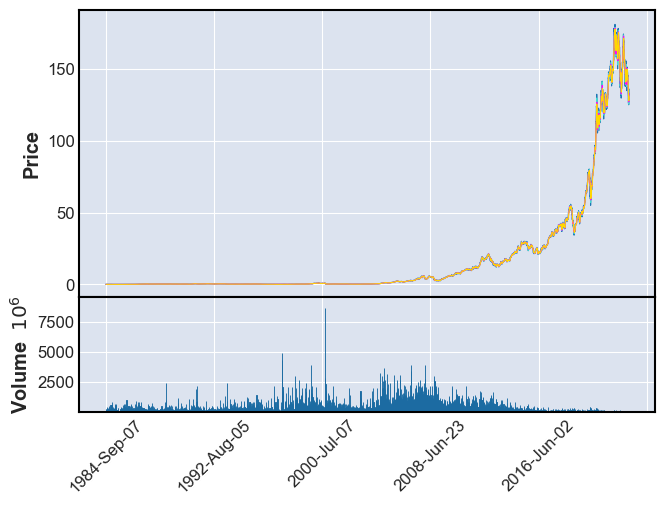

MSFTUS


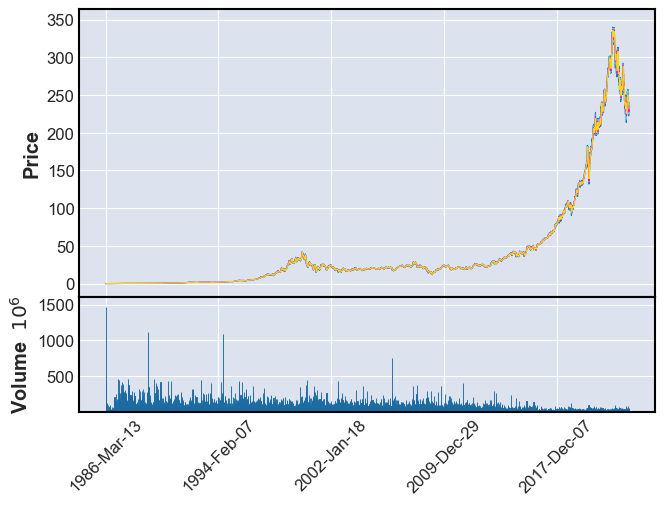

AMZNUS


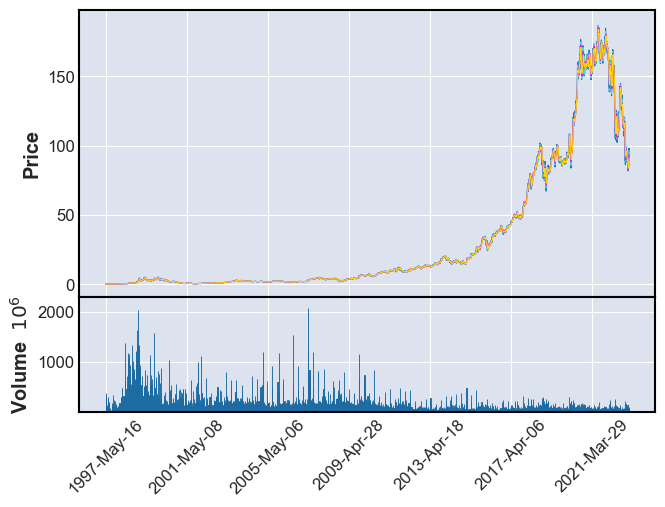

NVDAUS


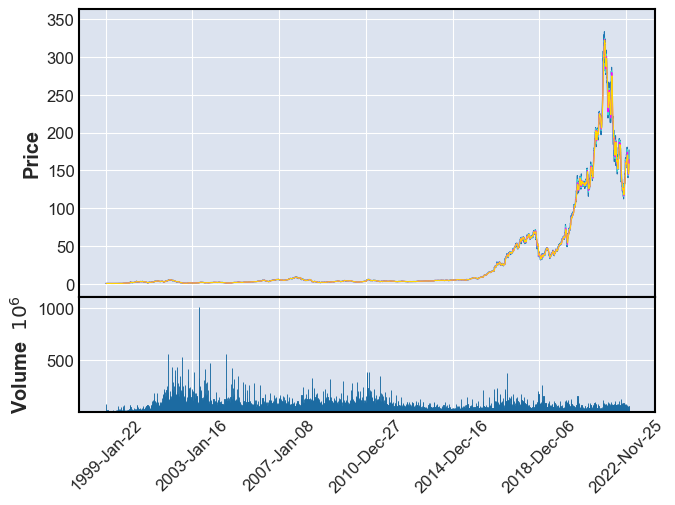

In [11]:
# Line graphs for chosen securities in portfollio
for security in portfolio_dict.keys():
    print(security)
    mpl.plot(securities[security], type='line', volume=True, mav=(3,6,9))

AAPLUS


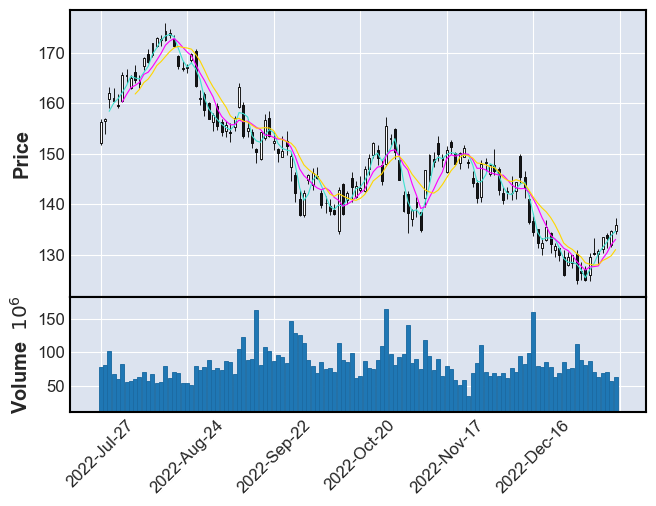

MSFTUS


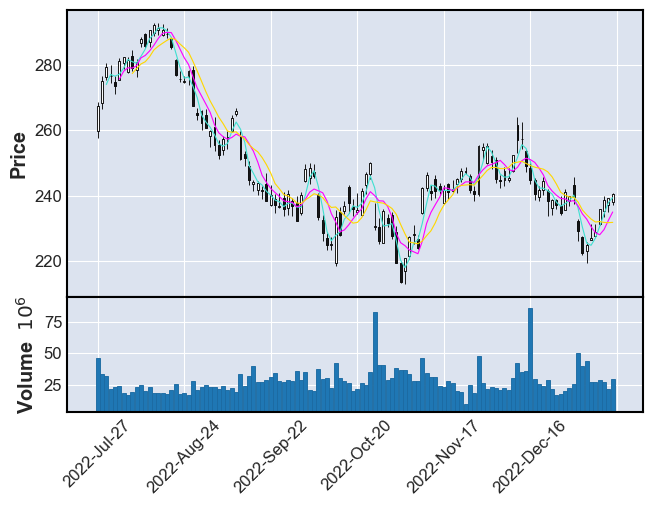

AMZNUS


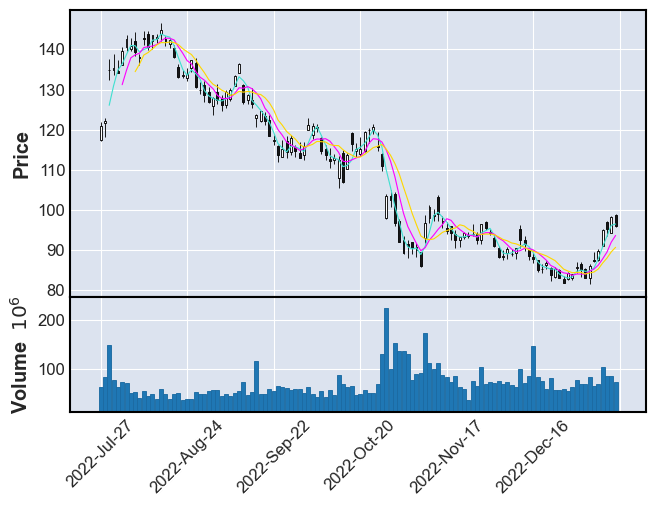

NVDAUS


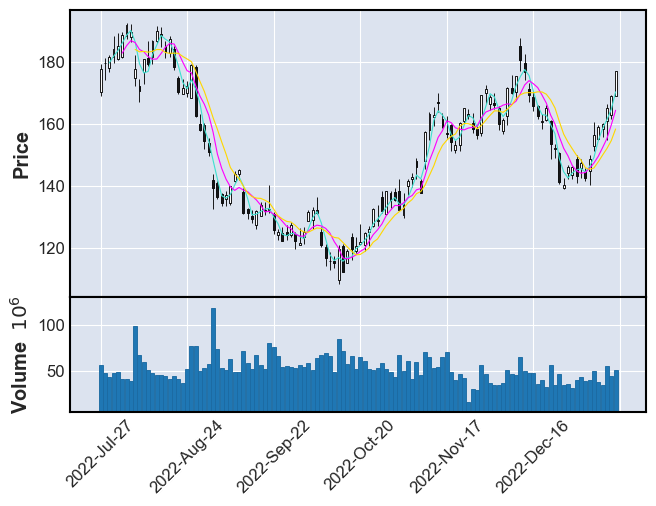

In [12]:
# Candle graphs for chosen securities in portfolio
for security in portfolio_dict.keys():
    print(security)
    mpl.plot(securities[security].tail(120), type='candle', volume=True, mav=(3,6,9))

### 2.2 Calculating portfolio statistics

In [13]:
#Creating portfolio

stocks = pd.DataFrame()
for item in portfolio_dict.keys():
    item = pd.Series(data=securities[item]["Close"], name=item)
    stocks = pd.merge(stocks, item, how='outer', left_index=True, right_index=True)
    

#Leaving only non-missing values for all observations (TBU : should we update missing values with last closing price?)
stocks = stocks[~stocks.isnull().any(axis=1)]

In [14]:
stocks

,AAPLUS,MSFTUS,AMZNUS,NVDAUS
Date,,,,
1999-01-22,0.294941,27.5433,3.0750,0.376292
1999-01-25,0.299896,28.5321,2.8095,0.415293
1999-01-26,0.307990,30.2336,2.8775,0.383147
1999-01-27,0.305329,29.7164,3.1405,0.383147
1999-01-28,0.311201,30.6665,3.0720,0.380859
...,...,...,...,...
2023-01-10,130.730000,228.8500,89.8700,159.090000
2023-01-11,133.490000,235.7700,95.0900,160.010000
2023-01-12,133.410000,238.5100,95.2700,165.110000


In [15]:
# Calculate daily returns from prices
stocks_dailyReturns = stocks.pct_change()

stocks_meanDailyReturns = stocks_dailyReturns.mean()
portfolio_return = np.sum(stocks_meanDailyReturns*list(portfolio_dict.values()))
print('Average historic daily portfolio return: ', str(np.round(portfolio_return, 4) * 100) + '%')

Average historic daily portfolio return:  0.12%


In [16]:
#Calculate daily portfolio returns
portfolio_dailyReturns = pd.DataFrame()
portfolio_dailyReturns["Portfolio"]= stocks_dailyReturns.dot(list(portfolio_dict.values()))
portfolio_dailyReturns

,Portfolio
Date,
1999-01-22,NaN
1999-01-25,0.017501
1999-01-26,0.008355
1999-01-27,0.016413
1999-01-28,0.005855
...,...
2023-01-10,0.014696
2023-01-11,0.028804
2023-01-12,0.011197


In [17]:
# Compound the percentage returns over time 
stocks_dailyCumRet=(1+stocks_dailyReturns).cumprod()
display(HTML(stocks_dailyCumRet.tail().to_html()))

portfolio_dailyCumRet=(1+portfolio_dailyReturns).cumprod()
display(portfolio_dailyCumRet.tail())

,AAPLUS,MSFTUS,AMZNUS,NVDAUS
Date,,,,
2023-01-10,443.241191,8.308736,29.226016,422.783370
2023-01-11,452.598994,8.559976,30.923577,425.228280
2023-01-12,452.327754,8.659456,30.982114,438.781585
2023-01-13,456.904940,8.685597,31.908943,449.092726
2023-01-17,460.905740,8.726260,31.235772,470.432536


,Portfolio
Date,
2023-01-10,301.901128
2023-01-11,310.597175
2023-01-12,314.074943
2023-01-13,319.300552
2023-01-17,322.482301


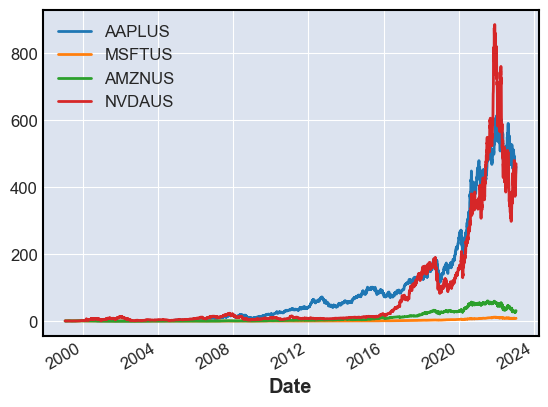

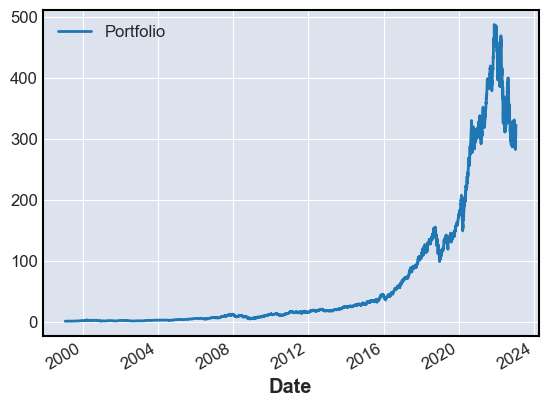

In [18]:
# Plot your cumulative return 
stocks_dailyCumRet.plot()
plt.show()
portfolio_dailyCumRet.plot()
plt.show()

In [19]:
#  The multiplication with 250 is to account for 250 trading days in a year.
stocks_covMatrix = stocks_dailyReturns.cov() * 250
display(stocks_covMatrix)
# Calculate the variance with the formula
portfolio_variance = np.dot(np.array(list(portfolio_dict.values())).T, np.dot(stocks_covMatrix, list(portfolio_dict.values())))


# Just converting the variance float into a percentage
print('Portfolio daily returns variance: ', str(np.round(portfolio_variance, 4) * 100) + '%')
print('Portfolio daily returns standard deviation: ', str(np.round(np.sqrt(portfolio_variance),4) * 100) + '%')

,AAPLUS,MSFTUS,AMZNUS,NVDAUS
AAPLUS,0.165363,0.059421,0.078383,0.100534
MSFTUS,0.059421,0.096235,0.070064,0.086369
AMZNUS,0.078383,0.070064,0.281915,0.105733
NVDAUS,0.100534,0.086369,0.105733,0.367158


Portfolio daily returns variance:  11.95%
Portfolio daily returns standard deviation:  34.57%


Good job! The standard deviation tells you how much the portfolio's return can deviate from the mean historical return. If a portfolio has a 12% average rate of return and a standard deviation of 4%, its return will range from 8-16%. The mean historic return of this particular portfolio is actually close to zero. With an average standard deviation of roughly 16%, this means you're getting a bad deal here! Now that you've learned how to calculate basic risk and return of a portfolio, you're ready to dive deeper into the world of portfolio analysis in the next chapters.

In [20]:
stocks

,AAPLUS,MSFTUS,AMZNUS,NVDAUS
Date,,,,
1999-01-22,0.294941,27.5433,3.0750,0.376292
1999-01-25,0.299896,28.5321,2.8095,0.415293
1999-01-26,0.307990,30.2336,2.8775,0.383147
1999-01-27,0.305329,29.7164,3.1405,0.383147
1999-01-28,0.311201,30.6665,3.0720,0.380859
...,...,...,...,...
2023-01-10,130.730000,228.8500,89.8700,159.090000
2023-01-11,133.490000,235.7700,95.0900,160.010000
2023-01-12,133.410000,238.5100,95.2700,165.110000


In [21]:
# Total return for stocks
years=(stocks.index[-1]-stocks.index[0])/ np.timedelta64(1, 'Y')

stocks_totalReturns = pd.DataFrame()

def total_return(data):
    return ((data[-1]-data[0])/data[0])
    
stocks_totalReturns["total_return"] = stocks.apply(total_return)
stocks_totalReturns["annualized_return"] = (((1+stocks_totalReturns["total_return"])**(1/years))-1)
print(stocks.index[0],' - portfolio start date')
print(stocks.index[-1],' - portfolio end date')
print(years,'years')
display(stocks_totalReturns)

1999-01-22 00:00:00  - portfolio start date
2023-01-17 00:00:00  - portfolio end date
23.986803288226316 years


,total_return,annualized_return
AAPLUS,459.905740,0.291353
MSFTUS,7.726260,0.094518
AMZNUS,30.235772,0.154281
NVDAUS,469.432536,0.292455


In [22]:
years

23.986803288226316

In [23]:
# Calculate annualized volatility from the standard deviation
# 250 accounts for 250 trading days in a year
stocks_volatility = stocks_dailyReturns.std() * np.sqrt(250)
display(stocks_volatility)

AAPLUS    0.406648
MSFTUS    0.310218
AMZNUS    0.530957
NVDAUS    0.605936
dtype: float64

In [24]:
# Calculate the Sharpe ratio 
stocks_sharpeRatio = ((stocks_totalReturns["annualized_return"] - rfr) / stocks_volatility)
display(stocks_sharpeRatio)

AAPLUS    0.716474
MSFTUS    0.304681
AMZNUS    0.290571
NVDAUS    0.482649
dtype: float64

In [25]:
portfolio_dailyReturns

,Portfolio
Date,
1999-01-22,NaN
1999-01-25,0.017501
1999-01-26,0.008355
1999-01-27,0.016413
1999-01-28,0.005855
...,...
2023-01-10,0.014696
2023-01-11,0.028804
2023-01-12,0.011197


In [26]:
portfolio = pd.DataFrame()
portfolio["Portfolio"] = pd.DataFrame(data=np.dot(stocks, list(portfolio_dict.values())))
portfolio.index=stocks.index
portfolio

,Portfolio
Date,
1999-01-22,7.822383
1999-01-25,8.014197
1999-01-26,8.450559
1999-01-27,8.386344
1999-01-28,8.607640
...,...
2023-01-10,152.135000
2023-01-11,156.090000
2023-01-12,158.075000


In [27]:
# Portfolio statistics
portfolio_totalReturns = pd.DataFrame()
portfolio_totalReturns["total_return"] = portfolio.apply(total_return)
portfolio_totalReturns["annualized_return"] = (((1+portfolio_totalReturns["total_return"])**(1/years))-1)
display(portfolio_totalReturns)

,total_return,annualized_return
Portfolio,19.753266,0.134772


In [28]:
print(portfolio_dailyReturns.mean())

Portfolio    0.001197
dtype: float64


In [29]:
portfolio_variance = portfolio_dailyReturns.std()
display(portfolio_variance)

Portfolio    0.021861
dtype: float64

In [30]:
portfolio_volatility = portfolio_dailyReturns.std() * np.sqrt(250)
display(portfolio_volatility)

Portfolio    0.345659
dtype: float64

In [31]:
portfolio_sharpeRatio = ((portfolio_totalReturns["annualized_return"] - rfr) / portfolio_volatility)
display(portfolio_sharpeRatio)

Portfolio    0.3899
dtype: float64

In [32]:
stocks_totalReturns["mean_dailyReturn"]=stocks_dailyReturns.mean()*100
stocks_totalReturns["std_dailyReturn"]=stocks_dailyReturns.std()*100
stocks_totalReturns["skew_dailyReturn"]=stocks_dailyReturns.skew()
stocks_totalReturns["kurtosis_dailyReturn"]=stocks_dailyReturns.kurtosis()

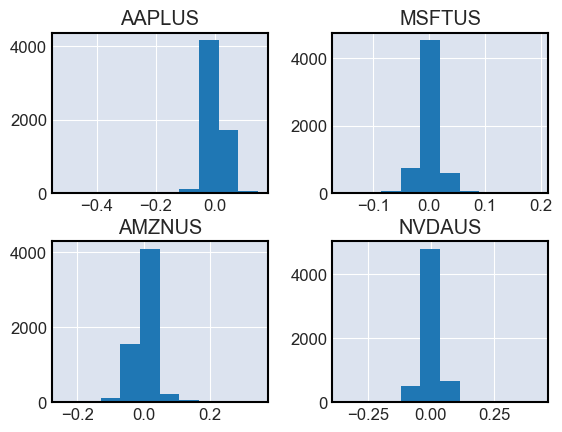

In [33]:
stocks_dailyReturns.hist()
plt.show()

In [34]:
stocks_totalReturns["sharpeRatio"]=stocks_sharpeRatio
stocks_totalReturns

,total_return,annualized_return,mean_dailyReturn,std_dailyReturn,skew_dailyReturn,kurtosis_dailyReturn,sharpeRatio
AAPLUS,459.905740,0.291353,0.136092,2.571867,-1.266713,31.167688,0.716474
MSFTUS,7.726260,0.094518,0.055145,1.961989,0.250473,9.267074,0.304681
AMZNUS,30.235772,0.154281,0.112497,3.358068,1.073935,13.119386,0.290571
NVDAUS,469.432536,0.292455,0.175007,3.832276,0.598944,11.414692,0.482649


abs(skew) > 1 - Highly skewed distribution
abs(skew) > 0.5 - Moderatly skewed distribution
abs(skew) <= 0.5 - Approximately symmetric distribution (MSFT)

kurtosis = 3 - mesocurtic (normal distribution)
kurtosis < 3 - piatycurtic (tails are shorter and thinner, central peak is lower and broader)
kurtosis > 3 - leptocurtic (tails are longer and fatter, central peak is higher and sharper (fat tailed))

In [35]:
sortino_ratio = pd.Series(index=stocks.columns, dtype='float64')
for item in stocks.columns:
    downside_returns = stocks_dailyReturns[item].loc[stocks_dailyReturns[item] < target_return]
    expected_return = stocks_dailyReturns[item].mean()
    down_stdev = downside_returns.std()
    sortino_temp = (expected_return - rfr)/down_stdev
    sortino_ratio.update(pd.Series([sortino_temp], index=[item]))

In [36]:
stocks_totalReturns["sortinoRatio"]=sortino_ratio
stocks_totalReturns

,total_return,annualized_return,mean_dailyReturn,std_dailyReturn,skew_dailyReturn,kurtosis_dailyReturn,sharpeRatio,sortinoRatio
AAPLUS,459.905740,0.291353,0.136092,2.571867,-1.266713,31.167688,0.716474,0.069159
MSFTUS,7.726260,0.094518,0.055145,1.961989,0.250473,9.267074,0.304681,0.038794
AMZNUS,30.235772,0.154281,0.112497,3.358068,1.073935,13.119386,0.290571,0.048227
NVDAUS,469.432536,0.292455,0.175007,3.832276,0.598944,11.414692,0.482649,0.066630


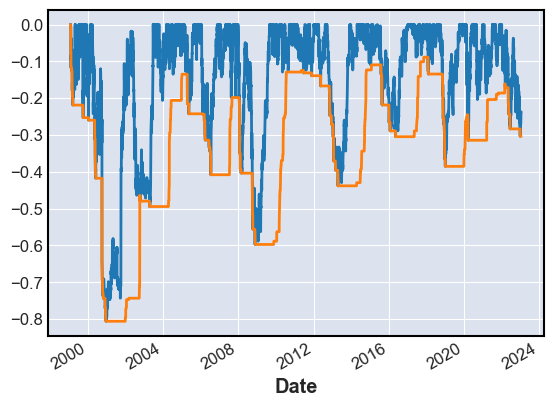

In [37]:
# Calculate the maximum value of returns using rolling().max()
roll_max = stocks['AAPLUS'].rolling(center=False, min_periods=1, window=250).max()
# Calculate daily draw-down from rolling max
daily_drawdown = stocks['AAPLUS']/roll_max - 1.0
# Calculate maximum daily draw-down
max_daily_drawdown = daily_drawdown.rolling(min_periods=1,window=250).min()
# Plot the results
daily_drawdown.plot()
max_daily_drawdown.plot()
plt.show()

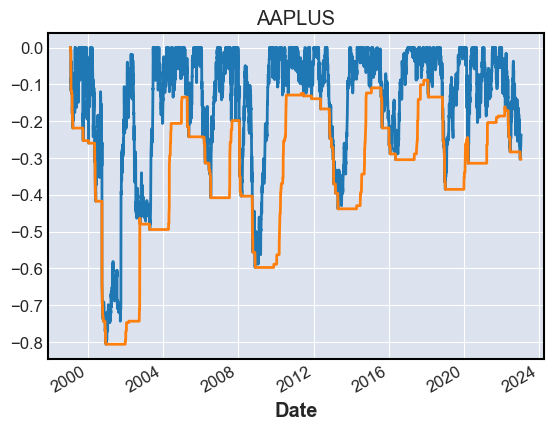

Biggest fall in analyzed period : - -0.8058


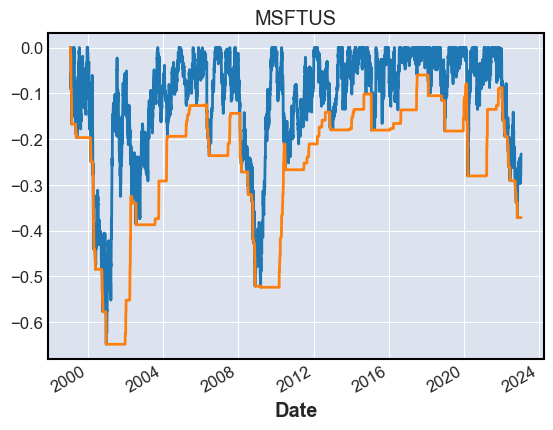

Biggest fall in analyzed period : - -0.648


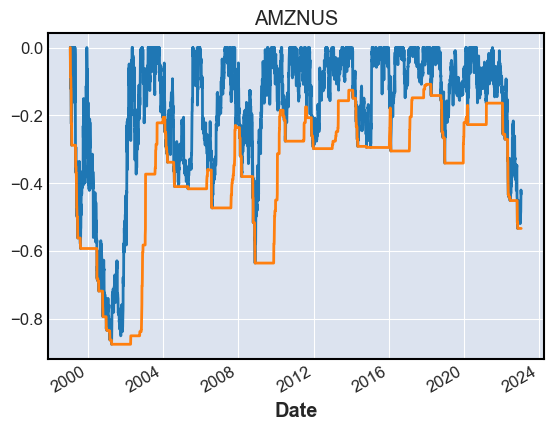

Biggest fall in analyzed period : - -0.8757


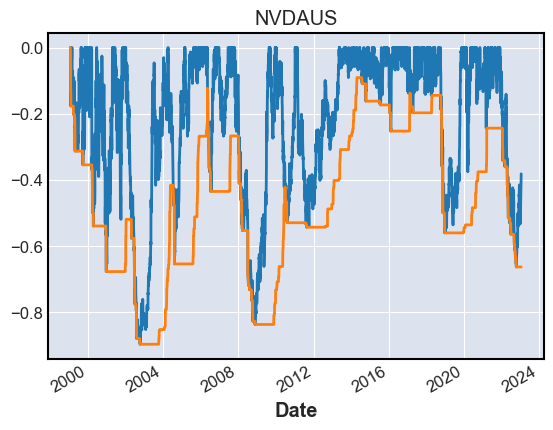

Biggest fall in analyzed period : - -0.8971


In [38]:
for stock in stocks:
    lookback_period = 250
    # Calculate the maximum value of returns using rolling().max()
    roll_max = stocks[stock].rolling(center = False, min_periods = 1, window = lookback_period).max()
    # Calculate daily draw-down from rolling max
    daily_drawdown = stocks[stock]/roll_max - 1.0
    # Calculate maximum daily draw-down
    max_daily_drawdown = daily_drawdown.rolling(center = False, min_periods = 1, window = lookback_period).min()
    daily_drawdown.plot()
    max_daily_drawdown.plot()
    plt.title(stock)
    plt.show()
    print('Biggest fall in analyzed period : -',round(min(max_daily_drawdown),4))


In [39]:
max_daily_drawdown.min()

-0.8970681502796363

In [40]:
daily_drawdown

Date
1999-01-22    0.000000
1999-01-25    0.000000
1999-01-26   -0.077406
1999-01-27   -0.077406
1999-01-28   -0.082915
                ...   
2023-01-10   -0.444404
2023-01-11   -0.441191
2023-01-12   -0.423380
2023-01-13   -0.409830
2023-01-17   -0.381786
Name: NVDAUS, Length: 6031, dtype: float64

In [41]:
# We want to calculate recovery time as well
# Our daily draw-down should be also time dependent i.e. from previous ATH

A stock is showing "momentum" if its prior 12-month average of returns is positive. The momentum factor is therefore formed by combining stocks that show consistent positive historic returns. The value factor looks at stocks that are inexpensive relative to some measure of fundamental value. For example price-to-earnings and price-to-book are typically ratios to measure "value". Let's see how our S&P500 returns relate to the returns of these factors. 

In [42]:
# Calculate expected returns mu 
mu = expected_returns.mean_historical_return(stocks)

In [43]:
# Calculate the covariance matrix S
Sigma = risk_models.sample_cov(stocks)

In [44]:
# Obtain the efficient frontier
ef = EfficientFrontier(mu, Sigma)
print (mu, Sigma)

AAPLUS    0.292157
MSFTUS    0.094758
AMZNUS    0.154684
NVDAUS    0.293262
dtype: float64           AAPLUS    MSFTUS    AMZNUS    NVDAUS
AAPLUS  0.166685  0.059897  0.079010  0.101338
MSFTUS  0.059897  0.097005  0.070624  0.087059
AMZNUS  0.079010  0.070624  0.284171  0.106579
NVDAUS  0.101338  0.087059  0.106579  0.370096


In [45]:
# Get the minimum risk portfolio for a target return 
weights = ef.efficient_return(0.25)
print (weights)

# Show portfolio performance 
ef.portfolio_performance(verbose=True)

OrderedDict([('AAPLUS', 0.6388060678620667), ('MSFTUS', 0.1837815740110011), ('AMZNUS', 0.0438341700615951), ('NVDAUS', 0.1335781880653372)])
Expected annual return: 25.0%
Annual volatility: 34.8%
Sharpe Ratio: 0.66


(0.25000000000000006, 0.34769186133538066, 0.6615052739993358)

In [46]:
# Calculate weights for the maximum Sharpe ratio portfolio
ef_ms = EfficientFrontier(mu, Sigma)
raw_weights_maxsharpe = ef_ms.max_sharpe()
cleaned_weights_maxsharpe = ef_ms.clean_weights()
print (raw_weights_maxsharpe, cleaned_weights_maxsharpe)
perf_max_sharpe=ef_ms.portfolio_performance(verbose=True)

OrderedDict([('AAPLUS', 0.8025421123378111), ('MSFTUS', 0.0), ('AMZNUS', 0.0), ('NVDAUS', 0.1974578876621889)]) OrderedDict([('AAPLUS', 0.80254), ('MSFTUS', 0.0), ('AMZNUS', 0.0), ('NVDAUS', 0.19746)])
Expected annual return: 29.2%
Annual volatility: 39.2%
Sharpe Ratio: 0.69


In [47]:
# Calculate weights for the maximum Sharpe ratio portfolio
ef_mv = EfficientFrontier(mu, Sigma)
raw_weights_minvolatility = ef_mv.min_volatility()
cleaned_weights_minvolatility = ef_mv.clean_weights()
print (raw_weights_minvolatility, cleaned_weights_minvolatility)
perf_min_volatility=ef_mv.portfolio_performance(verbose=True)

OrderedDict([('AAPLUS', 0.2373456886738853), ('MSFTUS', 0.6977056913112254), ('AMZNUS', 0.0649486200148894), ('NVDAUS', 0.0)]) OrderedDict([('AAPLUS', 0.23735), ('MSFTUS', 0.69771), ('AMZNUS', 0.06495), ('NVDAUS', 0.0)])
Expected annual return: 14.6%
Annual volatility: 29.4%
Sharpe Ratio: 0.43


In [48]:
print(cleaned_weights_minvolatility,cleaned_weights_maxsharpe,perf_min_volatility,perf_max_sharpe, sep="\n")

OrderedDict([('AAPLUS', 0.23735), ('MSFTUS', 0.69771), ('AMZNUS', 0.06495), ('NVDAUS', 0.0)])
OrderedDict([('AAPLUS', 0.80254), ('MSFTUS', 0.0), ('AMZNUS', 0.0), ('NVDAUS', 0.19746)])
(0.14550190637306748, 0.2940817033593309, 0.42675863523450797)
(0.29237479400858224, 0.39230787234639664, 0.6942883719857731)


In [49]:
Sigma

,AAPLUS,MSFTUS,AMZNUS,NVDAUS
AAPLUS,0.166685,0.059897,0.079010,0.101338
MSFTUS,0.059897,0.097005,0.070624,0.087059
AMZNUS,0.079010,0.070624,0.284171,0.106579
NVDAUS,0.101338,0.087059,0.106579,0.370096


In [50]:
# Exponential weights for matrix
# Define exponentially weightedSigma and mu using stock_prices
Sigma = risk_models.exp_cov(stocks, span=180, frequency=252)
mu = expected_returns.ema_historical_return(stocks, frequency=252, span=180)

# Calculate the efficient frontier
ef_exp_ms = EfficientFrontier(mu, Sigma)

# Calculate weights for the maximum sharpe ratio optimization 
# raw_exp_weights_maxsharpe = ef_exp_ms.max_sharpe() /UNCOMMENT LATER
# ValueError: at least one of the assets must have an expected return exceeding the risk-free rate
# cleaned_exp_weights_maxsharpe = ef_exp_ms.clean_weights() /UNCOMMENT LATER

# Show portfolio performance 
# ef_exp_ms.portfolio_performance(verbose=True) /UNCOMMENT LATER


Great work! Interesting isn't it, that by playing around with the span, you get two completely different type of portfolios, each with a very different Sharpe ratio. If your data is very volatile and changes rapidly, working with a short span might give you better predictive power of the expected return, with a faster moving investment strategy. However, if your data is rather slow moving as is the case with this data, the short span does not help you in better predicting expected risk and returns. Let's now recap what we've learned in this course

FACTOR MODELS - FOR EXAMPLE FAMA FRENCH MODEL 
Frequency resampling primer

Risk factor models often rely upon data that is of different frequencies. A typical example is when using quarterly macroeconomic data, such as prices, unemployment rates, etc., with financial data, which is often daily (or even intra-daily). To use both data sources in the same model, higher frequency data needs to be resampled to match the lower frequency data.

The DataFrame and Series Pandas objects have a built-in .resample() method that specifies the lower frequency. This method is chained with a method to create the lower-frequency statistic, such as .mean() for the average of the data within the new frequency period, or .min() for the minimum of the data.

In this exercise you'll practice converting daily returns data to weekly and quarterly frequency.

You've got the hang of it! Resampling is an oft-overlooked but extremely important tool for time series and risk factor analysis, and we'll use it in the following exercise.

Add a constant to the regression
mort_del = sm.add_constant(mort_del)

Create the regression factor model and fit it to the data
results = sm.OLS(port_q_mean, mort_del).fit()

Print a summary of the results
print(results.summary())

### Efficient frontier for exponential weights

In [51]:
# Exponential weights for matrix
# Compute the sample covariance matrix of returns
sample_cov = stocks.pct_change().cov() * 252
# Create the CovarianceShrinkage instance variable
cs = risk_models.CovarianceShrinkage(stocks)

#### Expected returns - same name as earlier
mu = expected_returns.mean_historical_return(stocks)
# Compute the efficient covariance matrix of returns
e_cov = cs.ledoit_wolf()

# Display both the sample covariance_matrix and the efficient e_cov estimate
print("Sample Covariance Matrix\n", sample_cov, "\n")
print("Efficient Covariance Matrix\n", e_cov, "\n")

efficient_portfolio = CLA(mu, e_cov)
print(efficient_portfolio.min_volatility())

Sample Covariance Matrix
           AAPLUS    MSFTUS    AMZNUS    NVDAUS
AAPLUS  0.166685  0.059897  0.079010  0.101338
MSFTUS  0.059897  0.097005  0.070624  0.087059
AMZNUS  0.079010  0.070624  0.284171  0.106579
NVDAUS  0.101338  0.087059  0.106579  0.370096 

Efficient Covariance Matrix
           AAPLUS    MSFTUS    AMZNUS    NVDAUS
AAPLUS  0.167103  0.059462  0.078436  0.100603
MSFTUS  0.059462  0.097929  0.070111  0.086427
AMZNUS  0.078436  0.070111  0.283736  0.105805
NVDAUS  0.100603  0.086427  0.105805  0.369037 

OrderedDict([('AAPLUS', 0.24135860719707508), ('MSFTUS', 0.6902031001305347), ('AMZNUS', 0.06843829267239024), ('NVDAUS', 0.0)])


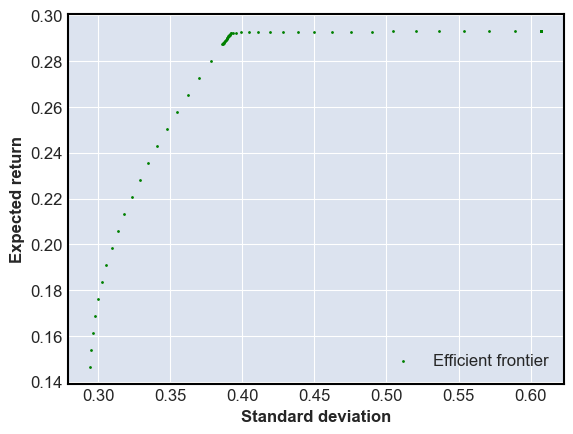

In [52]:
# Compute the efficient frontier
(ret, vol, weights) = efficient_portfolio.efficient_frontier()

# Add the frontier to the plot showing the 'before' and 'after' frontiers
plt.scatter(vol, ret, s = 4, c = 'g', marker = '.', label = 'Efficient frontier')
plt.xlabel('Standard deviation', fontsize=12)
plt.ylabel('Expected return', fontsize=12)
plt.legend()
plt.show()

### Efficient frontier in division per epochs

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1217: UserWarning: Parsing '31/12/2006' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  indexer = labels.slice_indexer(slice_obj.start, slice_obj.stop, slice_obj.step)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:6407: UserWarning: Parsing '31/12/2006' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  label = self._maybe_cast_slice_bound(label, side)
C:\Users\tgusc\AppData\Local\Temp\ipykernel_23268\2161859395.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Epoch_frontier = Epoch_frontier.append(frontier_new_data, ignore_index=True )


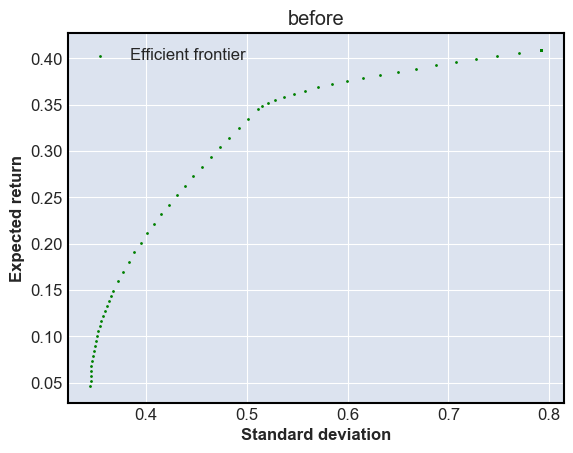

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1217: UserWarning: Parsing '31/12/2008' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  indexer = labels.slice_indexer(slice_obj.start, slice_obj.stop, slice_obj.step)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:6407: UserWarning: Parsing '31/12/2008' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  label = self._maybe_cast_slice_bound(label, side)
C:\Users\tgusc\AppData\Local\Temp\ipykernel_23268\2161859395.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Epoch_frontier = Epoch_frontier.append(frontier_new_data, ignore_index=True )


OrderedDict([('AAPLUS', 0.19750938350604874), ('MSFTUS', 0.7425580121835074), ('AMZNUS', 0.054990287208443435), ('NVDAUS', 0.004942317102000603)])


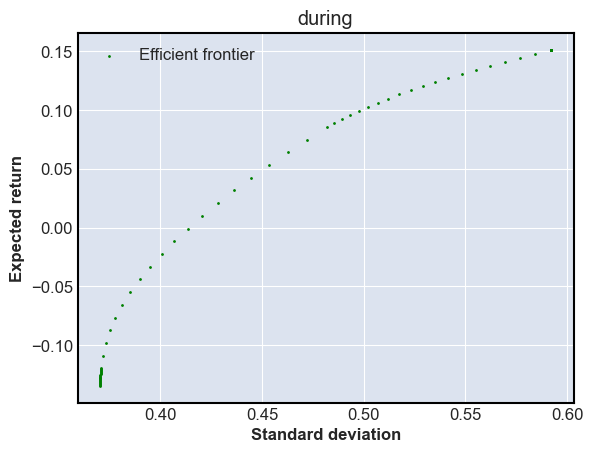

OrderedDict([('AAPLUS', 0.22422283692667067), ('MSFTUS', 0.7052240619326883), ('AMZNUS', 0.05173600914676259), ('NVDAUS', 0.018817091993878664)])


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1217: UserWarning: Parsing '31/12/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  indexer = labels.slice_indexer(slice_obj.start, slice_obj.stop, slice_obj.step)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:6407: UserWarning: Parsing '31/12/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  label = self._maybe_cast_slice_bound(label, side)
C:\Users\tgusc\AppData\Local\Temp\ipykernel_23268\2161859395.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Epoch_frontier = Epoch_frontier.append(frontier_new_data, ignore_index=True )


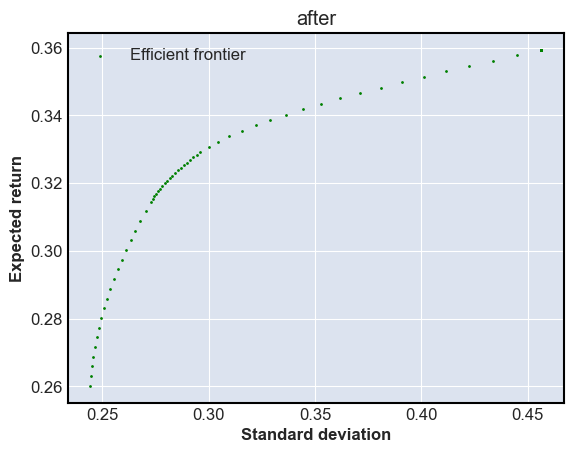

OrderedDict([('AAPLUS', 0.3624734488262384), ('MSFTUS', 0.49944774162978645), ('AMZNUS', 0.13807880954397522), ('NVDAUS', 0.0)])


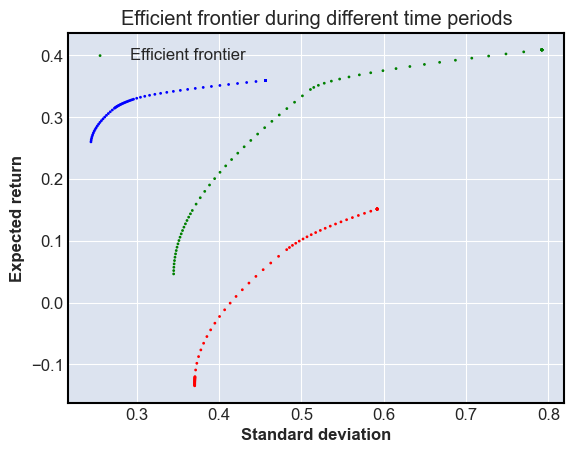

In [53]:
# Create a dictionary of time periods (or 'epochs')
epochs = { 'before' : {'start': '1/1/1900', 'end': '31/12/2006'},
           'during' : {'start': '1/1/2007', 'end': '31/12/2008'},
           'after'  : {'start': '1/1/2009', 'end': '31/12/2022'}
         }

# Compute the efficient covariance for each epoch
mu_epoch = {}
e_cov_epoch = {}
efficient_portfolio_epoch = {}
Epoch_frontier = pd.DataFrame(columns =['returns','volume','epoch'])

for xi in epochs.keys():
    sub_price = stocks.loc[epochs[xi]['start']:epochs[xi]['end']]
    mu_epoch[xi] = expected_returns.mean_historical_return(sub_price)
    e_cov_epoch[xi] = risk_models.CovarianceShrinkage(sub_price).ledoit_wolf()
    efficient_portfolio_epoch[xi] = CLA(mu_epoch[xi], e_cov_epoch[xi])
    (ret, vol, weights) = efficient_portfolio_epoch[xi].efficient_frontier()
    frontier_new_data = pd.concat([pd.Series(ret), pd.Series(vol)], axis=1, keys=('returns','volume'))
    frontier_new_data["epoch"]=xi
    Epoch_frontier = Epoch_frontier.append(frontier_new_data, ignore_index=True )
    
    plt.scatter(vol, ret, s = 4, c = 'g', marker = '.')
    plt.title(xi)
    plt.legend(['Efficient frontier'])
    plt.xlabel('Standard deviation', fontsize=12)
    plt.ylabel('Expected return', fontsize=12)
    plt.show()
    print(efficient_portfolio_epoch[xi].min_volatility())   

# Display the efficient covariance matrices for all epochs

colors = {'before':'green', 'during':'red', 'after':'blue'}


plt.scatter(Epoch_frontier["volume"], Epoch_frontier["returns"], s = 4, c = Epoch_frontier['epoch'].map(colors), marker = '.')
plt.title('Efficient frontier during different time periods')
plt.legend(['Efficient frontier'])
plt.xlabel('Standard deviation', fontsize=12)
plt.ylabel('Expected return', fontsize=12)
plt.show()

In [54]:
print("Efficient Covariance Matrices\n", e_cov_epoch)

Efficient Covariance Matrices
 {'before':           AAPLUS    MSFTUS    AMZNUS    NVDAUS
AAPLUS  0.294858  0.072722  0.109446  0.141178
MSFTUS  0.072722  0.133533  0.089164  0.107430
AMZNUS  0.109446  0.089164  0.552668  0.149035
NVDAUS  0.141178  0.107430  0.149035  0.627500, 'during':           AAPLUS    MSFTUS    AMZNUS    NVDAUS
AAPLUS  0.245150  0.100863  0.158341  0.155547
MSFTUS  0.100863  0.150890  0.114211  0.121264
AMZNUS  0.158341  0.114211  0.350651  0.160970
NVDAUS  0.155547  0.121264  0.160970  0.451432, 'after':           AAPLUS    MSFTUS    AMZNUS    NVDAUS
AAPLUS  0.084765  0.044925  0.047733  0.067565
MSFTUS  0.044925  0.072773  0.051587  0.068053
AMZNUS  0.047733  0.051587  0.120845  0.071435
NVDAUS  0.067565  0.068053  0.071435  0.208327}


In [55]:
print("Efficient Covariance Matrices\n", mu_epoch)

Efficient Covariance Matrices
 {'before': AAPLUS    0.315855
MSFTUS   -0.020078
AMZNUS   -0.054590
NVDAUS    0.409097
dtype: float64, 'during': AAPLUS    0.009354
MSFTUS   -0.193543
AMZNUS    0.151437
NVDAUS   -0.421331
dtype: float64, 'after': AAPLUS    0.317109
MSFTUS    0.213808
AMZNUS    0.278150
NVDAUS    0.359367
dtype: float64}


### Value-at-Risk (VaR)

In [56]:
portfolio

,Portfolio
Date,
1999-01-22,7.822383
1999-01-25,8.014197
1999-01-26,8.450559
1999-01-27,8.386344
1999-01-28,8.607640
...,...
2023-01-10,152.135000
2023-01-11,156.090000
2023-01-12,158.075000


In [57]:
portfolio_return

0.0011968524920567157

1.6448536269514722
95% VaR:  1.6448536269514722 ; 99% VaR:  2.3153060251201265


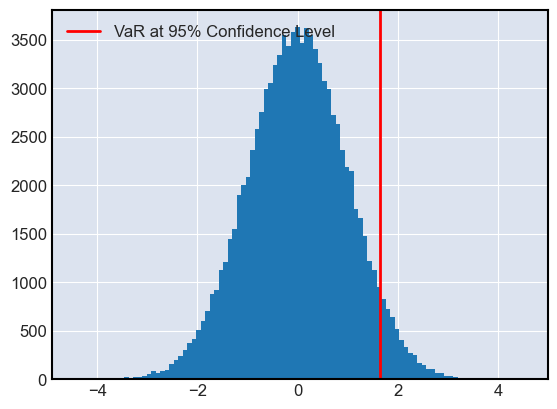

In [58]:
# assuming normal distribution

VaR_95 = stats.norm.ppf(0.95)
print(VaR_95)
draws = stats.norm.rvs(size = 100000)
VaR_99 = np.quantile(draws, 0.99)

# Compare the 95% and 99% VaR
print("95% VaR: ", VaR_95, "; 99% VaR: ", VaR_99)

# Plot the normal distribution histogram and 95% VaR measure
plt.hist(draws, bins = 100)
plt.axvline(x = VaR_95, c='r', label = "VaR at 95% Confidence Level")
plt.legend()
plt.show()

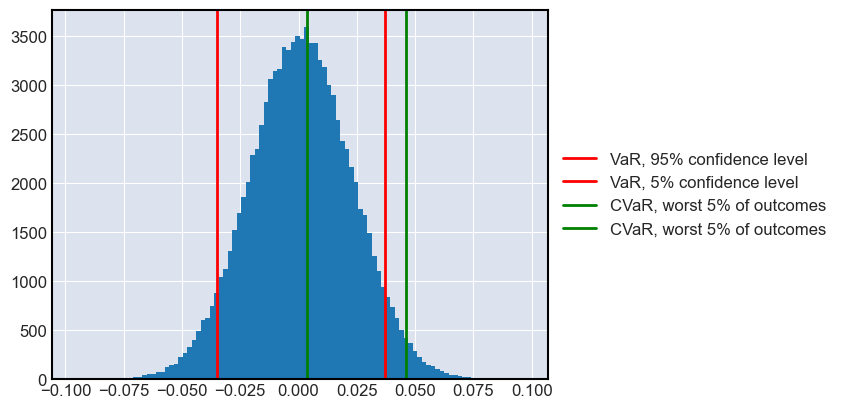

In [59]:
# Compute the mean and standard deviation of the portfolio returns
pm = portfolio_dailyReturns.mean()[0]
ps = portfolio_dailyReturns.std()[0]

# Compute the 95% VaR using the .ppf()
VaR_95 = stats.norm.ppf(0.95, loc = pm, scale = ps)
VaR_05 = stats.norm.ppf(0.05, loc = pm, scale = ps) # To be confirmed if I can use that
# Compute the expected tail loss and the CVaR in the worst 5% of cases
tail_loss = stats.norm.expect(lambda x: x, loc = pm, scale = ps, lb = VaR_95)
tail_loss_b = stats.norm.expect(lambda x: x, loc = pm, scale = ps, lb = VaR_05) # To be confirmed if I can use that
# ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all()
CVaR_95 = (1 / (1 - 0.95)) * tail_loss
CVaR_05 = (1 / (1 - 0.05)) * tail_loss_b

# Plot the normal distribution histogram and add lines for the VaR and CVaR
plt.hist(stats.norm.rvs(size = 100000, loc = pm, scale = ps), bins = 100)
plt.axvline(x = VaR_95, c='r', label = "VaR, 95% confidence level")
plt.axvline(x = VaR_05, c='r', label = "VaR, 5% confidence level")
plt.axvline(x = CVaR_95, c='g', label = "CVaR, worst 5% of outcomes")
plt.axvline(x = CVaR_05, c='g', label = "CVaR, worst 5% of outcomes") # To be confirmed if I can use that
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

it's generally the case that CVaR is the preferred risk measure for risk management. One reason is that it is affected by the tail of the loss distribution, while VaR is a static value. 

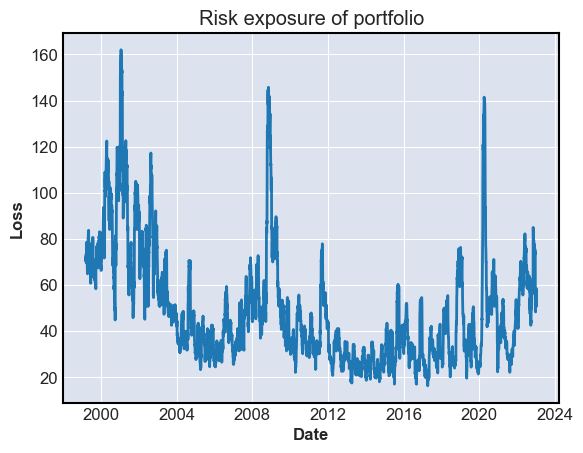

In [60]:
# Create rolling window parameter list
mu = portfolio_dailyReturns.rolling(30).mean()
# Need to convert DataFrame to Series for the enumerator to work correctly
mu = mu.squeeze()
sigma = portfolio_dailyReturns.rolling(30).std()
sigma = sigma.squeeze()
rolling_parameters = [(29, mu[i], s) for i,s in enumerate(sigma)]

# Compute the 99% VaR array using the rolling window parameters
VaR_99 = np.array( [ stats.t.ppf(0.99, *params) 
                    for params in rolling_parameters ] )

# Plot the minimum risk exposure over the 2005-2010 time period
plt.plot(portfolio_dailyReturns.index, 0.01 * VaR_99 * 100000)
plt.title('Risk exposure of portfolio')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.show()

In [61]:
# Fit the Student's t distribution to crisis losses

# We can also estimate this on losses, for example assuming losses = -portfolio_dailyReturns[1:]

p = stats.t.fit(portfolio_dailyReturns[1:]) #Excluding first observation because of 'NaN' value

# Compute the VaR_99 for the fitted distribution
VaR_99 = stats.t.ppf(0.99, *p)

# Use the fitted parameters and VaR_99 to compute CVaR_99
tail_loss = stats.t.expect(lambda y: y, args = (p[0],), loc = p[1], scale = p[2], lb = VaR_99 )
CVaR_99 = (1 / (1 - 0.99)) * tail_loss
print(CVaR_99)

0.09900331355372494


Recall that CVaR is the expected value of loss given a minimum loss threshold. So CVaR is already in the form of a risk exposure--it is the sum (or integral) of the probability of loss in the distribution tail multiplied, by the loss amount.

Great! The Student's t-distribution is widely used when the Normal distribution is too restrictive for portfolio losses, but still allows convergence to the Normal when the sample size becomes very large.

In [62]:
def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy
    All parameters are necessary
    Later move to beginning - functions section
    """
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = stats.gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    #original: return kde.evaluate(x_grid)
    return kde

# Kernel density - funkcja gęstości
# https://pl.wikipedia.org/wiki/Funkcja_g%C4%99sto%C5%9Bci_prawdopodobie%C5%84stwa
# https://www.szkolnictwo.pl/szukaj,Funkcja_g%C4%99sto%C5%9Bci_prawdopodobie%C5%84stwa
# https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/


In [63]:
# Need to convert DataFrame to Series for the enumerator to work correctly
# We can also estimate this on losses, for example assuming losses = -portfolio_dailyReturns[1:]
xd = portfolio_dailyReturns[1:].squeeze()

# We require to fit a distribution - obtain gaussian_kde class object
fitted = kde_scipy(x = xd, x_grid = np.linspace(-0.25, 0.25, 1000))
print(type(fitted))


<class 'scipy.stats.kde.gaussian_kde'>


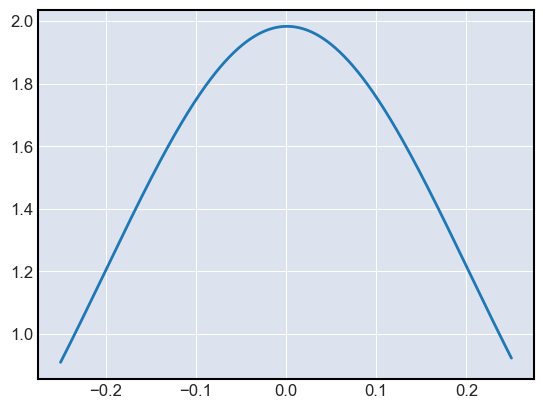

0.33295589686674426


In [64]:
# VaR from a fitted distribution
# Visualize the fitted distribution with a plot


# In this exercise a fitted loss distribution is provided, 
# which fits losses from an equal-weighted investment bank portfolio from 2005-2010.
x = np.linspace(-0.25,0.25,1000)
plt.plot(x,fitted.evaluate(x))
plt.show()

# Create a random sample of 100,000 observations from the fitted distribution
sample = fitted.resample(100000)

# Compute and display the 95% VaR from the random sample
VaR_95 = np.quantile(sample, .95)
print(VaR_95)

In [65]:
# Import the EfficientCVaR class
from pypfopt.efficient_frontier import EfficientCVaR

# We can also estimate this on losses, for example assuming losses = -stocks_dailyReturns

# Create the efficient frontier for CVaR minimization
ec = EfficientCVaR(None, stocks_dailyReturns)

# Find the cVaR-minimizing portfolio weights at the default 95% confidence level
optimal_weights = ec.min_cvar()

# Map the values in optimal_weights to the bank names
optimal_weights = {stocks_dailyReturns.columns[i] : optimal_weights[i] for i in optimal_weights}
# Display the optimal weights
print(optimal_weights)


{'AAPLUS': 0.2469273292506584, 'MSFTUS': 0.6851652753327643, 'AMZNUS': 0.0679073954165728, 'NVDAUS': 4.6e-15}


C:\Users\tgusc\AppData\Roaming\Python\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:152: UserWarning: Removing NaNs from returns
  warnings.warn(


CVaR risk management and the crisis

In this exercise you'll derive the 95% CVaR-minimizing portfolio for 2005-2006, 2007-2008, and 2009-2010. These are the periods (or 'epochs') before, during and after the crisis.

- before : to 2006
- during : 2007-2008
- after : 2009+

In [66]:
returns_dict = {}
for xi in epochs.keys():
    returns_dict[xi] = stocks_dailyReturns.loc[epochs[xi]['start']:epochs[xi]['end']]

# Initialize the efficient portfolio dictionary
ec_dict = {}
min_vol = {}

# For each epoch, assign an efficient frontier cvar instance to ec
for xi in ['before', 'during', 'after']: 
    ec_dict[xi] = EfficientCVaR(None, returns_dict[xi])

#print(returns_dict)
print(ec_dict)

{'before': <pypfopt.efficient_frontier.efficient_cvar.EfficientCVaR object at 0x0000022B9890C7F0>, 'during': <pypfopt.efficient_frontier.efficient_cvar.EfficientCVaR object at 0x0000022B9890CF40>, 'after': <pypfopt.efficient_frontier.efficient_cvar.EfficientCVaR object at 0x0000022B992C5220>}


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1217: UserWarning: Parsing '31/12/2006' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  indexer = labels.slice_indexer(slice_obj.start, slice_obj.stop, slice_obj.step)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:6407: UserWarning: Parsing '31/12/2006' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  label = self._maybe_cast_slice_bound(label, side)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1217: UserWarning: Parsing '31/12/2008' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  indexer = labels.slice_indexer(slice_obj.start, slice_obj.stop, slice_obj.step)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:6407: UserWarning: Parsing '31/12/2008' in DD/MM/YYYY format. Provide format or specify inf

In [67]:
# Initialize the dictionary of optimal weights
opt_wts_dict = {}

# Find and display the CVaR-minimizing portfolio weights at the default 95% confidence level
for x in ['before', 'during', 'after']:
    opt_wts_dict[x] = ec_dict[x].min_cvar()
    # map bank names to optimal weights
    opt_wts_dict[x] = {stocks_dailyReturns.columns[i] : opt_wts_dict[x][i] for i in opt_wts_dict[x]}

# Compare the CVaR-minimizing weights to the minimum volatility weights for the 'before' epoch
for x in ['before', 'during', 'after']:
    print("Before \n")
    print("CVaR:\n", opt_wts_dict[x], "\n")
    print("Min Vol:\n", efficient_portfolio_epoch[x].min_volatility(), "\n")

Before 

CVaR:
 {'AAPLUS': 0.228227856298764, 'MSFTUS': 0.6786422165043511, 'AMZNUS': 0.0773135208606164, 'NVDAUS': 0.0158164063362684} 

Min Vol:
 OrderedDict([('AAPLUS', 0.19750938350604874), ('MSFTUS', 0.7425580121835074), ('AMZNUS', 0.054990287208443435), ('NVDAUS', 0.004942317102000603)]) 

Before 

CVaR:
 {'AAPLUS': 0.2933678472832932, 'MSFTUS': 0.658940570292053, 'AMZNUS': 0.0290727124153738, 'NVDAUS': 0.01861887000928} 

Min Vol:
 OrderedDict([('AAPLUS', 0.22422283692667067), ('MSFTUS', 0.7052240619326883), ('AMZNUS', 0.05173600914676259), ('NVDAUS', 0.018817091993878664)]) 

Before 

CVaR:
 {'AAPLUS': 0.3745168969158177, 'MSFTUS': 0.4726594887920059, 'AMZNUS': 0.1528236142921716, 'NVDAUS': 4.9e-15} 

Min Vol:
 OrderedDict([('AAPLUS', 0.3624734488262384), ('MSFTUS', 0.49944774162978645), ('AMZNUS', 0.13807880954397522), ('NVDAUS', 0.0)]) 



In [68]:
# The Black-Scholes option pricing formula for European options
# Adapted from: Black, F., & Scholes, M. (1973). The Pricing of Options and Corporate Liabilities. Journal of Political Economy, 81(3), 637-654, www.jstor.org/stable/1831029.
# MIT License
# Copyright (c) 2019 Jamsheed Shorish

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this file "black_scholes.py" (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
# 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
# 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

import numpy as np
from scipy.stats import norm


# Auxiliary function for d_one risk-adjusted probability
def d11(S, X, T, r, sigma):
    """This is an auxiliary function and is not intended to be called externally."""
    return (np.log(S/X) + (r + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))

# Auxiliary function for d_two risk-adjusted probability    
def d21(d1, T, sigma):
    """This is an auxiliary function and is not intended to be called externally."""
    return d1 - sigma * np.sqrt(T)

# Definition of the Black-Scholes delta function    
def bs_delta(S, X, T, r, sigma, option_type):
    """Compute the delta of the Black-Scholes option pricing formula.
    
    Arguments:
    S           -- the current spot price of the underlying stock
    X           -- the option strike price
    T           -- the time until maturity (in fractions of a year)
    r           -- the risk-free interest rate 
    sigma       -- the returns volatility of the underlying stock
    option_type -- the option type, either 'call' or 'put'
    
    Returns: a numpy.float_ representing the delta value
    Exceptions raised: ValueError if option_type is not 'call' or 'put'
    """
    if option_type == 'call':
        return norm.cdf(d11(S, X, T, r, sigma))
    elif option_type == 'put':
        return norm.cdf(-d11(S, X, T, r, sigma))
    else:
        # Raise an error if the option_type is neither a call nor a put
        raise ValueError("Option type is either 'call' or 'put'.")

# Definition of the Black-Scholes European option pricing formula    
def black_scholes(S, X, T, r, sigma, option_type):
    """Price a European option using the Black-Scholes option pricing formula.
    
    Arguments:
    S           -- the current spot price of the underlying stock
    X           -- the option strike price
    T           -- the time until maturity (in fractions of a year)
    r           -- the risk-free interest rate 
    sigma       -- the returns volatility of the underlying stock
    option_type -- the option type, either 'call' or 'put'
    
    Returns: a numpy.float_ representing the option value
    Exceptions raised: ValueError if option_type is not 'call' or 'put'
    """
    d_one = d11(S, X, T, r, sigma)
    d_two = d21(d_one, T, sigma)
    if option_type == 'call':
        return S * norm.cdf(d_one) - np.exp(-r * T) * X * norm.cdf(d_two)
    elif option_type == 'put':
        return -(S * norm.cdf(-d_one) - np.exp(-r * T) * X * norm.cdf(-d_two))
    else:
        # Raise an error if the option_type is neither a call nor a put
        raise ValueError("Option type is either 'call' or 'put'.")

In [69]:
# BLACK-SCHOLES OPTION PRICING - HEDGING
# Compute the volatility as the annualized standard deviation of IBM returns
sigma = np.sqrt(252) * portfolio_dailyReturns[1:].std()

# Compute the Black-Scholes option price for this volatility
value_s = black_scholes(S = 90, X = 80, T = 0.5, r = 0.02, 
                        sigma = sigma, option_type = "call")

# Compute the Black-Scholes option price for twice the volatility
value_2s = black_scholes(S = 90, X = 80, T = 0.5, r = 0.02, 
                sigma = 2*sigma, option_type = "call")

# Display and compare both values
print("Option value for sigma: ", value_s, "\n",
      "Option value for 2 * sigma: ", value_2s)

Option value for sigma:  [14.74774665] 
 Option value for 2 * sigma:  [22.33877299]


Nice job. As shown, the value of the call option increases with an increase in volatility! This is because an option only needs to be exercised when it is profitable to do so, which means that more volatility increases the chance for profit. In the next exercise, you'll examine how an option's profitability changes instead with the price of the underlying stock over time.

Options pricing and the underlying asset

Options are essentially bets on the future evolution of the underlying asset's price.

For example, a put option is valuable when the spot (market) price falls below the option's strike price. The option holder may exercise the option to sell the underlying at the strike
, and buy it back at the spot S < X, yielding profit X - S 
In this exercise you'll value and visualize a European put option on IBM stock, again applying the Black-Scholes pricing formula, as the spot S changes.

The strike X = 140, the time to maturity T is 1/2 a year, and the risk-free interest rate is 2%.

The annualized volatility of IBM is available as sigma, and the plotting axis option_axis is available to add your plot.

You can find the source code of the black_scholes() function here [ https://assets.datacamp.com/production/repositories/5157/datasets/f275319f10cf6bd59d01a98eb8d960178eedc945/black_scholes.py ]

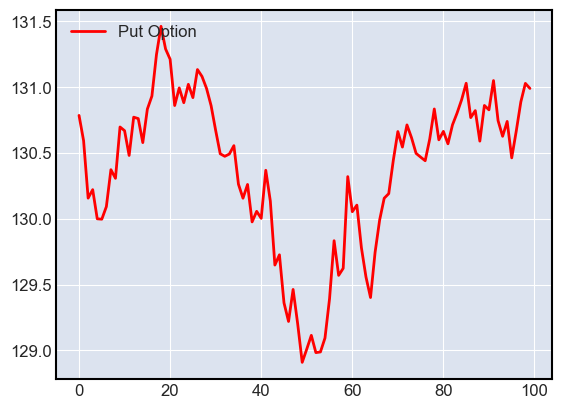

In [70]:
# Select the first 100 observations of IBM data
Portfolio_spot = portfolio[:100]

# Initialize the European put option values array
option_values = np.zeros(Portfolio_spot.size)

# Iterate through IBM's spot price and compute the option values
for i,S in enumerate(Portfolio_spot.values):
    option_values[i] = black_scholes(S = S, X = 140, T = 0.5, r = 0.02, 
                        sigma = sigma, option_type = "put")

# Display the option values array
plt.plot(option_values, color = "red", label = "Put Option")
plt.legend(loc = "upper left")
plt.show()

Exactly! As you can see, the value of the option rises whenever the price of IBM falls (and vice-versa). This shows that an option is a good candidate for hedging changes in IBM's stock price.

Using options for hedging

Suppose that you have an investment portfolio with one asset, IBM. You'll hedge the portfolio's risk using delta hedging with a European put option on IBM.

First, value the European put option using the Black-Scholes option pricing formula, with a strike X of 80 and a time to maturity T of 1/2 a year. The risk-free interest rate is 2% and the spot S is initially 70.

Then create a delta hedge by computing the delta of the option with the bs_delta() function, and use it to hedge against a change in the stock price to 69.5. The result is a delta neutral portfolio of both the option and the stock.

Both of the functions black_scholes() and bs_delta() are available in your workspace.

You can find the source code of the black_scholes() and bs_delta() functions here.

In [71]:
# Compute the annualized standard deviation of `IBM` returns
sigma = np.sqrt(252) * portfolio_dailyReturns[1:].std()

# Compute the Black-Scholes value at IBM spot price 70
value = black_scholes(S = 130, X = 140, T = 0.5, r = 0.02, 
                      sigma = sigma, option_type = "put")
# Find the delta of the option at IBM spot price 70
delta = bs_delta(S = 130 , X = 140, T = 0.5, r = 0.02, 
                 sigma = sigma, option_type = "put")

# Find the option value change when the price of IBM falls to 69.5
value_change = black_scholes(S = 129, X = 140, T = 0.5, r = 0.02, 
                             sigma = sigma, option_type = "put") - value

print( (129 - 130) + (1/delta) * value_change )

[0.0111683]


Excellent! The price change in IBM has been offset using the option delta. You've hedged risk the way institutional risk managers do it, which is how pension funds keep their value. Important stuff!

Parameter estimation: Normal

Parameter estimation is the strongest method of VaR estimation because it assumes that the loss distribution class is known. Parameters are estimated to fit data to this distribution, and statistical inference is then made.

In this exercise, you will estimate the 95% VaR from a Normal distribution fitted to the investment bank data from 2007 - 2009. You'll use scipy.stats's norm distribution, assuming that it's the most appropriate class of distribution.

Is a Normal distribution a good fit? You'll test this with the scipy.stats.anderson Anderson-Darling test. If the test result is statistically different from zero, this indicates the data is not Normally distributed. You'll address this in the next exercise.

Portfolio losses for the 2005 - 2010 period are available.

In [72]:
# Import the Normal distribution and skewness test from scipy.stats
from scipy.stats import norm, anderson

# Fit portfolio losses to the Normal distribution
params = norm.fit(portfolio_dailyReturns[1:])

# Compute the 95% VaR from the fitted distribution, using parameter estimates
VaR_95 = norm.ppf(0.95, *params)
print("VaR_95, Normal distribution: ", VaR_95)

# Test the data for Normality
print("Anderson-Darling test result: ", anderson(portfolio_dailyReturns[1:].squeeze()))

VaR_95, Normal distribution:  0.0371526447585789
Anderson-Darling test result:  AndersonResult(statistic=74.32393067413068, critical_values=array([0.576, 0.656, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


The Anderson-Darling test value of 74.62 exceeds the 99% critical value of 1.086 by a large margin, indicating that the Normal distribution may be a poor choice to represent portfolio losses.

Parameter estimation: Skewed Normal

In the previous exercise you found that fitting a Normal distribution to the investment bank portfolio data from 2005 - 2010 resulted in a poor fit according to the Anderson-Darling test.

You will test the data using the skewtest() function from scipy.stats. If the test result is statistically different from zero, then the data support a skewed distribution.

Now you'll parametrically estimate the 95% VaR of a loss distribution fit using scipy.stats's skewnorm skewed Normal distribution. This is a more general distribution than the Normal and allows losses to be non-symmetrically distributed. We might expect losses to be skewed during the crisis, when portfolio losses were more likely than gains.

Portfolio losses for the 2007 - 2009 period are available.

In [73]:
# Import the skew-normal distribution and skewness test from scipy.stats
from scipy.stats import skewnorm, skewtest

# Test the data for skewness
print("Skewtest result: ", skewtest(portfolio_dailyReturns[1:].squeeze()))

# Fit the portfolio loss data to the skew-normal distribution
params = skewnorm.fit(portfolio_dailyReturns[1:])

# Compute the 95% VaR from the fitted distribution, using parameter estimates
VaR_95 = skewnorm.ppf(0.95, *params)
print("VaR_95 from skew-normal: ", VaR_95)

Skewtest result:  SkewtestResult(statistic=4.866835838918727, pvalue=1.1339914590923741e-06)
VaR_95 from skew-normal:  0.037743319220119476


Note that although the VaR estimate for the Normal distribution from the previous exercise is larger than the skewed Normal distribution estimate, the Anderson-Darling and skewtest results show the Normal distribution estimates cannot be relied upon. Skewness matters for loss distributions, and parameter estimation is one way to quantify this important feature of the financial crisis.

Historical Simulation

Historical simulation of VaR assumes that the distribution of historical losses is the same as the distribution of future losses. We'll test if this is true for our investment bank portfolio by comparing the 95% VaR from 2005 - 2006 to the 95% VaR from 2007 - 2009.

The list asset_returns has been created for you, which contains asset returns for each of the two periods. You'll use this list to create portfolio_returns with the available weights, and use this to derive portfolio losses.

Then you'll use the np.quantile() function to find the 95% VaR for each period. If the loss distributions are the same, then the 95% VaR estimate should be about the same for both periods. Otherwise the distribution might have changed as the global financial crisis took hold.

In [74]:
stocks_dailyReturns

,AAPLUS,MSFTUS,AMZNUS,NVDAUS
Date,,,,
1999-01-22,NaN,NaN,NaN,NaN
1999-01-25,0.016800,0.035900,-0.086341,0.103646
1999-01-26,0.026989,0.059635,0.024204,-0.077406
1999-01-27,-0.008640,-0.017107,0.091399,0.000000
1999-01-28,0.019232,0.031972,-0.021812,-0.005972
...,...,...,...,...
2023-01-10,0.004456,0.007617,0.028732,0.017981
2023-01-11,0.021112,0.030238,0.058084,0.005783
2023-01-12,-0.000599,0.011621,0.001893,0.031873


In [75]:
portfolio_dict

{'AAPLUS': 0.25, 'MSFTUS': 0.25, 'AMZNUS': 0.25, 'NVDAUS': 0.25}

In [76]:
stocks_dailyReturns

,AAPLUS,MSFTUS,AMZNUS,NVDAUS
Date,,,,
1999-01-22,NaN,NaN,NaN,NaN
1999-01-25,0.016800,0.035900,-0.086341,0.103646
1999-01-26,0.026989,0.059635,0.024204,-0.077406
1999-01-27,-0.008640,-0.017107,0.091399,0.000000
1999-01-28,0.019232,0.031972,-0.021812,-0.005972
...,...,...,...,...
2023-01-10,0.004456,0.007617,0.028732,0.017981
2023-01-11,0.021112,0.030238,0.058084,0.005783
2023-01-12,-0.000599,0.011621,0.001893,0.031873


In [77]:
# Create portfolio returns for the two sub-periods using the list of asset returns
# For two sub-periods daily returns would have to be list of lists - we will do this for one period
portfolio_returns = np.array(stocks_dailyReturns[1:]).dot(list(portfolio_dict.values()))

# Derive portfolio losses from portfolio returns
losses = -portfolio_returns

#stocks_dailyReturns.dot(portfolio_weights)
# Find the historical simulated VaR estimates
VaR_95 = np.quantile(losses, 0.95)
# Display the VaR estimates
print("VaR_95 :", VaR_95)

VaR_95 : 0.0352664655822927


Monte Carlo Simulation

You can use Monte Carlo simulation of the 2005-2010 investment bank portfolio assets to find the 95% VaR.

The mean asset losses are in the Numpy array mu. The efficient covariance matrix is e_cov (note that here we're using the daily, not annualized variance as in previous exercises). You'll use these to create sample paths for asset losses over one day, to simulate the daily portfolio loss.

Using the covariance matrix e_cov allows asset paths to be correlated, which is a realistic assumption.

The simulation total_steps is set to 1440, as in the video. The number of runs N is set to 10000.

For each run you'll compute the cumulative losses, and then apply the np.quantile() function to find the 95% VaR.

Portfolio weights and scipy.stats's norm distribution are available.

In [78]:
e_cov

,AAPLUS,MSFTUS,AMZNUS,NVDAUS
AAPLUS,0.167103,0.059462,0.078436,0.100603
MSFTUS,0.059462,0.097929,0.070111,0.086427
AMZNUS,0.078436,0.070111,0.283736,0.105805
NVDAUS,0.100603,0.086427,0.105805,0.369037


In [91]:
# Exponential weights for matrix
# Create the CovarianceShrinkage instance variable
cs = risk_models.CovarianceShrinkage(stocks)
#### Expected returns
mu = expected_returns.mean_historical_return(stocks)
# Compute the efficient covariance matrix of returns
e_cov = cs.ledoit_wolf()

In [92]:
# Initialize daily cumulative loss for the assets, across N runs
# At our code we assess this currently for returns
N = 1000
total_steps = 1440

# Initialize daily cumulative loss for the assets, across N runs
daily_loss = np.zeros((4,N))


# mu - expected returns:

mu = np.reshape(np.array(mu), (4,1))

# Create the Monte Carlo simulations for N runs
for n in range(N):
    # Compute simulated path of length total_steps for correlated returns
    correlated_randomness = e_cov @ norm.rvs(size = (4,total_steps))
    # Adjust simulated path by total_steps and mean of portfolio losses
    steps = 1/total_steps
    minute_losses = mu * steps + correlated_randomness * np.sqrt(steps)
    daily_loss[:, n] = minute_losses.sum(axis=1)
    
# Generate the 95% VaR estimate
losses = list(portfolio_dict.values()) @ daily_loss
daily_loss
print("Monte Carlo VaR_95 estimate:", np.quantile(losses, 0.95))

Monte Carlo VaR_95 estimate: 0.6250346933469288


Fantastic! You've shown how Monte Carlo simulation can be used to create an entire range of possible outcomes when the underlying risk factor distributions are known. The resulting riskiness of the loss distribution can then be assessed using the VaR estimate, or a more complicated estimate such as CVaR.

Crisis structural break: I

You have already seen in Chapters 1 and 2 that the global financial crisis changed investor perception regarding market risk, and influenced investor decisions on portfolio allocations to manage risk.

Now you'll have a chance to investigate whether something "structural" changed between 2005 and 2010. In this exercise you can see if quarterly minimum portfolio values and mean return volatility time series together identify a structural break.

You'll check this first with a simple visualization of the data. Plot the quarterly minimum portfolio returns port_q_min and mean return volatility vol_q_mean to identify a date where a structural break may have occurred.

In [81]:
portfolio = pd.DataFrame()
portfolio["Portfolio"] = pd.DataFrame(data=np.dot(stocks, list(portfolio_dict.values())))
portfolio.index=stocks.index
portfolio

,Portfolio
Date,
1999-01-22,7.822383
1999-01-25,8.014197
1999-01-26,8.450559
1999-01-27,8.386344
1999-01-28,8.607640
...,...
2023-01-10,152.135000
2023-01-11,156.090000
2023-01-12,158.075000


In [82]:
# Prepare quarterly data for porfolio returns
#convert date column to datetime
portfolio_dailyReturns.index = pd.to_datetime(portfolio_dailyReturns.index)

#calculate values, grouped by quarter
port_q_min = portfolio_dailyReturns.resample('Q', convention='end').min()
vol_q_min = portfolio_dailyReturns.resample('Q', convention='end').std()

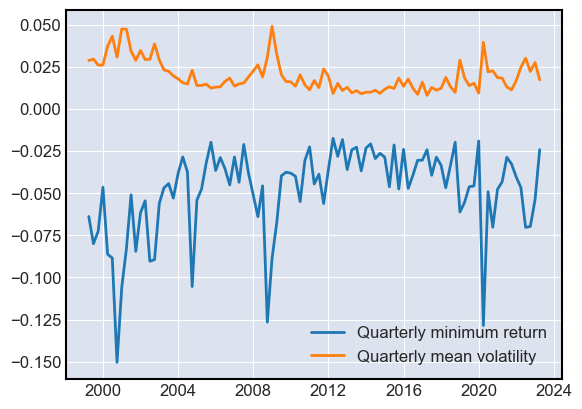

In [83]:
# Create a plot of quarterly minimum portfolio returns
plt.plot(port_q_min, label="Quarterly minimum return")

# Create a plot of quarterly mean volatility
plt.plot(vol_q_min, label="Quarterly mean volatility")

# Create legend and plot
plt.legend()
plt.show()

As you can see from the visualization, there appears to be a discrete change somewhere in the first half of 2008, but it's unclear if this is just a temporary 'blip' or something more structural. We'll now proceed to test this by building the Chow test statistic.

Crisis structural break: II

The video identified a structural break for a simple relationship between population size and time in China. In this and the following exercise you'll use the richer factor model relationship between portfolio returns and mortgage delinquencies from Chapter 1 to test for a structural break around 2008, by computing the Chow test statistic for the factor model.

First, after importing the statsmodels API, you'll run an OLS regression for 2005 - 2010, with quarterly minimum returns port_q_min as the dependent variable, and mortgage delinquencies mort_del as the independent variable (plus an intercept term).

Take note of the sum of squared residuals ssr_total from the regression result (this will be provided in the next exercise to help derive the Chow test statistic).

In [84]:
# Import the statsmodels API to be able to run regressions
import statsmodels.api as sm

# Mortgage delinquencies data source - https://fred.stlouisfed.org/series/DRSFRMACBS
mort_del = pd.read_excel('./data_add/DRSFRMACBS.xls', header = 10, sheet_name='FRED Graph', parse_dates=['observation_date'], 
                        index_col = 'observation_date')

# Adjusting index values of mortgage delinquencies (beginning of quarter to end of quarter)
mort_del.index = [date - pd.tseries.offsets.DateOffset(days=1) + pd.tseries.offsets.QuarterEnd() for date in  mort_del.index]
mort_del

# Selecting only values that are also present in port_q_min dataframe
mort_idx = mort_del.index.intersection(port_q_min.index)
mort_del_x = mort_del.loc[mort_idx]
mort_del_x

# Selecting only values that are also present in mort_del_x dataframe
port_idx = port_q_min.index.intersection(mort_del_x.index)
port_q_min_x = port_q_min.loc[port_idx]

# Add a constant to the regression
mort_del_x = sm.add_constant(mort_del_x)

# Regress quarterly minimum portfolio returns against mortgage delinquencies
result = sm.OLS(port_q_min_x, mort_del_x).fit()

# Retrieve the sum-of-squared residuals
ssr_total = result.ssr
print("Sum-of-squared residuals, 2005-2010: ", ssr_total)

Sum-of-squared residuals, 2005-2010:  0.056129612370459346


Good. The sum-of-squared residual total you found here will be brought over into the next exercise, where it will be used to build the Chow test for the crisis period!


Crisis structural break: III

Now you can put everything together to perform the Chow test.

The 2005 - 2010 data have been split into two available DataFrames, before and after, using June 30, 2008 as the structural break point (identified in the first exercise in this series). The columns of both DataFrames are mort_del and returns for mortgage delinquency data and returns data, respectively.

You'll run two OLS regressions on before and after, regressing the returns column against the mort_del column in each DataFrame, and derive the sum-of-squared residuals.

Then you'll compute the Chow test statistic as in the video, using ssr_total (provided from the second exercise) and the derived residuals. The critical F-value at 99% confidence is around 5.85. What value do you find for your test statistic?


In [85]:
# Now for subperiods-
# Create a dictionary of time periods (or 'epochs')
epochs = { 'before' : {'start': '1/1/1900', 'end': '31/12/2006'},
           'after'  : {'start': '1/1/2007', 'end': '31/12/2022'}
         }

port_before = port_q_min_x.loc[epochs['before']['start']:epochs['before']['end']]
mort_before = mort_del_x.loc[epochs['before']['start']:epochs['before']['end']]
port_after = port_q_min_x.loc[epochs['after']['start']:epochs['after']['end']]
mort_after = mort_del_x.loc[epochs['after']['start']:epochs['after']['end']]


# Add intercept constants to each sub-period 'before' and 'after'
before_with_intercept = sm.add_constant(mort_before['DRSFRMACBS'])
after_with_intercept  = sm.add_constant(mort_after['DRSFRMACBS'])

# Fit OLS regressions to each sub-period
r_b = sm.OLS(port_before['Portfolio'], before_with_intercept).fit()
r_a = sm.OLS(port_after['Portfolio'],  after_with_intercept).fit()

# Get sum-of-squared residuals for both regressions
ssr_before = r_b.ssr
ssr_after = r_a.ssr
# Compute and display the Chow test statistic
data_points = mort_del.size
k = r_a.params.shape[0]

numerator = ((ssr_total - (ssr_before + ssr_after)) / k)
denominator = ((ssr_before + ssr_after) / (data_points - 2*k))
print("Chow test statistic: ", numerator / denominator)

Chow test statistic:  11.561617490393687


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1217: UserWarning: Parsing '31/12/2006' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  indexer = labels.slice_indexer(slice_obj.start, slice_obj.stop, slice_obj.step)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:6407: UserWarning: Parsing '31/12/2006' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  label = self._maybe_cast_slice_bound(label, side)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1217: UserWarning: Parsing '31/12/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  indexer = labels.slice_indexer(slice_obj.start, slice_obj.stop, slice_obj.step)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:6407: UserWarning: Parsing '31/12/2022' in DD/MM/YYYY format. Provide format or specify inf

Excellent! Your test statistic was well above the critical F-value, indicating that a structural break in the data occurred in the summer of 2008. We'll investigate the consequences of such a structural break for risk management in Chapter 4.

Volatility and structural breaks

Visualizing volatility changes helps reveal possible structural break points in time series. By identifying when volatility appears to change, an informed choice of break point can be made that can, in turn, be used for further statistical analysis (such as the Chow test).

You'll examine two visualizations of volatility for the investment bank portfolio from 2008 - 2009, for two available portfolio weights: weights_with_citi and weights_without_citi. These correspond, respectively, to equal-weighted portfolios with and without Citibank, which exhibited (as you saw in Chapter 1) the highest volatility of the four assets over the period.

The portfolio prices for 2008 - 2009 with Citibank are available as prices_with_citi, and without Citibank as prices_without_citi.

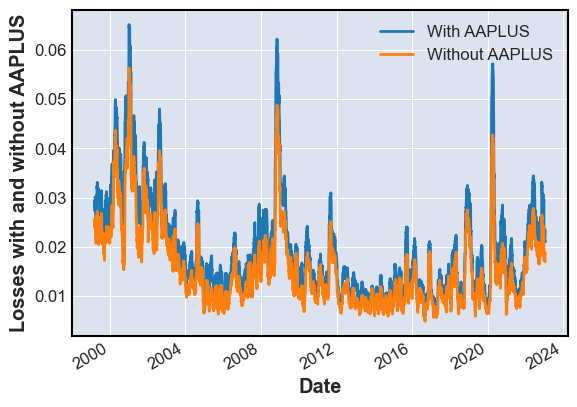

In [86]:
# https://www.geeksforgeeks.org/copy-python-deep-copy-shallow-copy/

# Find the time series of returns with and without chosen company
company_excluded = 'AAPLUS'

# data for portfolio with excluded company
stocks_wo = stocks_dailyReturns.loc[:, stocks_dailyReturns.columns != company_excluded]
dict_wo = copy.deepcopy(portfolio_dict)
del dict_wo[company_excluded]

ret_with_company = portfolio_dailyReturns
ret_without_company = stocks_wo.dot(list(dict_wo.values()))

# Find the average 30-day rolling window volatility as the standard deviation
columns={'old_name':company_excluded}

# DataFrame type
vol_with_company = ret_with_company.rolling(30).std().dropna().rename(columns = {"Portfolio":"With " + company_excluded})
# Series type
vol_without_company = ret_without_company.rolling(30).std().dropna()
vol_without_company.name = "Without " + company_excluded
# Combine two volatilities into one Pandas DataFrame
vol = pd.concat([vol_with_company, vol_without_company], axis=1)

# Plot volatilities over time
vol.plot().set_ylabel("Losses with and without AAPLUS")
plt.show()

Nice job. The visualizations show that Citibank's volatility alone was not responsible for the increase in portfolio volatility during the crisis. This lends futher support to a structural break sometime around the summer/fall of 2008.

Extreme values and backtesting

Extreme values are those which exceed a threshold and are used to determine if risk measures such as VaR are accurately reflecting the risk of loss.

You'll explore extreme values by computing the 95% VaR of the equally-weighted investment bank portfolio for 2009-2010 (recall that this is equivalent to historical simulation from 2010 onwards), and then backtesting on data from 2007-2008.

2009-2010 portfolio losses are available in estimate_data, from which you'll compute the 95% VaR estimate. Then find extreme values exceeding the VaR estimate, from the 2007-2008 portfolio losses in the available backtest_data.

Compare the relative frequency of extreme values to the 95% VaR, and finally visualize the extreme values with a stem plot.

Extreme values and backtesting

Extreme values are those which exceed a threshold and are used to determine if risk measures such as VaR are accurately reflecting the risk of loss.

You'll explore extreme values by computing the 95% VaR of the equally-weighted investment bank portfolio for 2009-2010 (recall that this is equivalent to historical simulation from 2010 onwards), and then backtesting on data from 2007-2008.

2009-2010 portfolio losses are available in estimate_data, from which you'll compute the 95% VaR estimate. Then find extreme values exceeding the VaR estimate, from the 2007-2008 portfolio losses in the available backtest_data.

Compare the relative frequency of extreme values to the 95% VaR, and finally visualize the extreme values with a stem plot.

VaR_95:  0.028209482779324183 ; Backtest - ratio of losses exceeding 95% VaR :  0.17786561264822134 ( 45 obs)


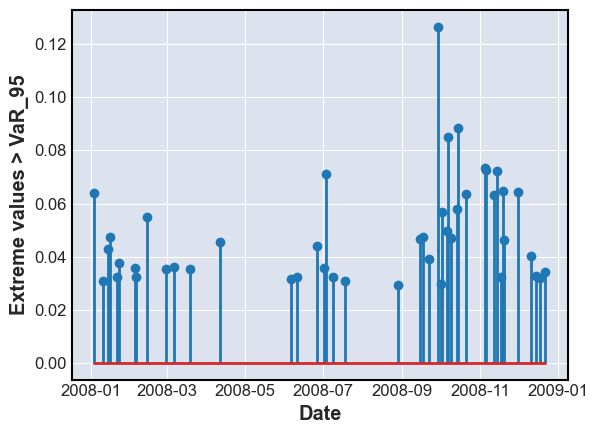

In [96]:
# Splitting period to estimate VAR and back-test VAR
epochs = { 'before' : {'start': '1/1/1900', 'end': '31/12/2008'},
          'backtest': {'start': '1/1/2008', 'end': '31/12/2008'},
           'after'  : {'start': '1/1/2009', 'end': '31/12/2022'}
         }
# losess = - returns
estimate_data = -portfolio_dailyReturns.loc[epochs['after']['start']:epochs['after']['end']]
backtest_data = -portfolio_dailyReturns.loc[epochs['backtest']['start']:epochs['backtest']['end']]

VaR_95 = np.quantile(estimate_data, 0.95)
# Find backtest_data exceeding the 95% VaR
extreme_values = backtest_data[backtest_data["Portfolio"] > VaR_95]

# Compare the fraction of extreme values for 2007-2008 to the Var_95 estimate
print("VaR_95: ", VaR_95, "; Backtest - ratio of losses exceeding 95% VaR : ", len(extreme_values)*1.0 / len(backtest_data)*1.0, '(',len(extreme_values),'obs)')

# Plot the extreme values and look for clustering
plt.stem(extreme_values.index, extreme_values)
plt.ylabel("Extreme values > VaR_95"); plt.xlabel("Date")
plt.show()


Great! Since the relative frequency of extreme events in 2007-2008 is higher than 5%, the estimate of the 95% VaR from 2009-2010 data is not robust across the possible structural break identified in the previous exercise. Backtesting remains an important verifier of risk measure estimates such as VaR.

Block maxima

Until now you've worked with a portfolio of four investment banks for the period 2005 - 2010. Now you'll zero in on a single asset, the stock of General Electric, for the same period and apply extreme value theory to its time series.

In this exercise, you'll examine the time series of block maxima for GE's losses over the period 2008 - 2009, using the .resample() method for three different block lengths: one week, one month, and one quarter, visualizing each series in a plot using the axis_* plot objects.

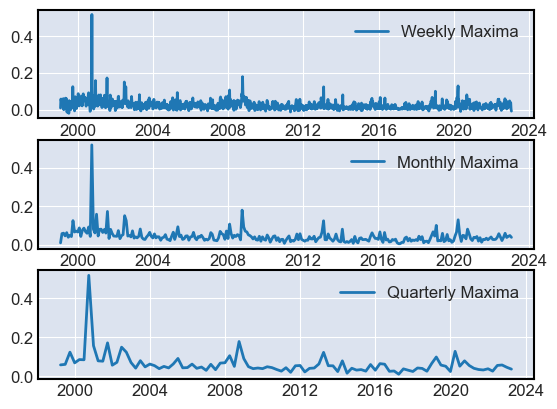

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [104]:
# Taking returns from a single chosen stock and calculating losses
company = 'AAPLUS'

losses = -stocks_dailyReturns[company]

# Resample the data into weekly blocks
weekly_maxima = losses.resample("W").max()

# Plot the resulting weekly maxima
figsize = 8
fig, (axis_1, axis_2, axis_3) = plt.subplots(nrows = 3, ncols = 1)
axis_1.plot(weekly_maxima, label = "Weekly Maxima")
axis_1.legend()
plt.figure("weekly")

# Resample the data into monthly blocks
monthly_maxima = losses.resample("M").max()

# Plot the resulting monthly maxima
axis_2.plot(monthly_maxima, label = "Monthly Maxima")
axis_2.legend()
plt.figure("monthly")

# Resample the data into quarterly blocks
quarterly_maxima = losses.resample("Q").max()

# Plot the resulting quarterly maxima
axis_3.plot(quarterly_maxima, label = "Quarterly Maxima")
axis_3.legend()
plt.figure("quarterly")
plt.show()

In [ ]:
# 2023/01/19 - Try to plot 3 graphs on 1 plot with different colours

Good! As you can see, GE's losses were high and volatile during the crisis. Concentrating on the block maxima provides information about the tail of the loss distribution, which is critical for risk management.